In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# let's silence all the annoying Future warnings from Pandas:
import pandas as pd

In [3]:
np.random.seed(seed=42)

In [4]:
annot = sc.read_h5ad("./saline.h5ad")
adata = sc.read_h5ad("./psilo_both.h5ad")

In [5]:
adata.obs = adata.obs.join(annot.obs["annot"])

In [6]:
del annot

In [7]:
adata

AnnData object with n_obs × n_vars = 25018 × 25328
    obs: 'condition', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'annot'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [8]:
adata.layers["counts"] = adata.X.copy()

In [9]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.layers["logcounts"] = adata.X.copy()

# naive (no integration)

In [10]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


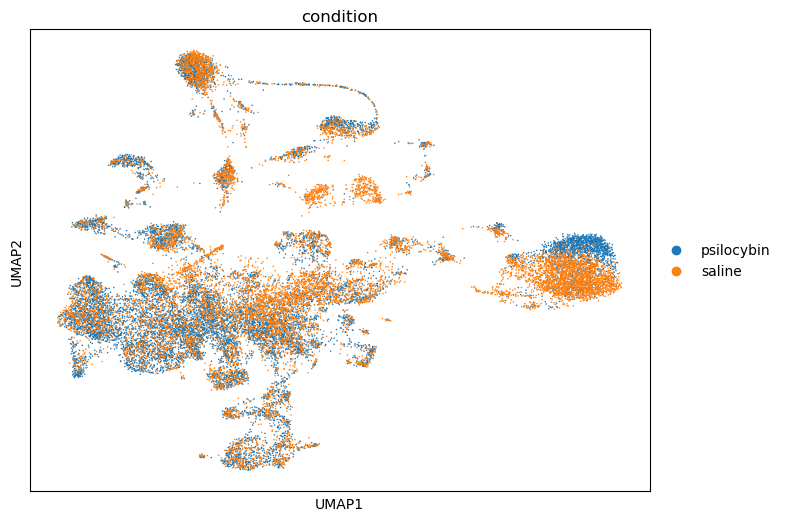

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(adata, color="condition", ax=ax)

# batch-aware HVG

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="condition")

highly_variable_nbatches
0    22580
1     1496
2     1252
Name: count, dtype: int64

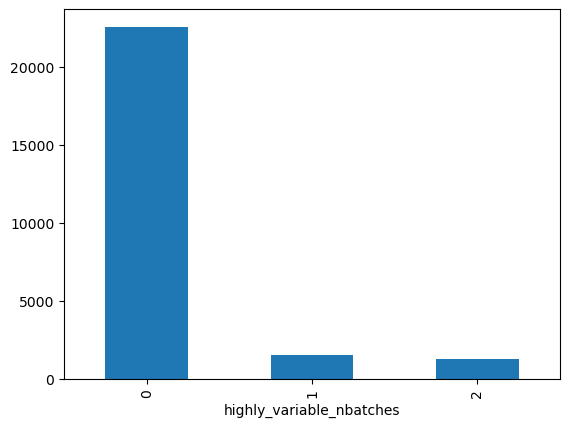

In [13]:
n_batches = adata.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [14]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()

# BBKNN

In [15]:
import bbknn

In [16]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.scale(adata_bbknn)
sc.pp.pca(adata_bbknn)

In [17]:
bbknn.bbknn(adata_bbknn, batch_key="condition")
sc.tl.leiden(adata_bbknn)
bbknn.ridge_regression(adata_bbknn, batch_key=['condition'], confounder_key=['leiden'])
sc.tl.pca(adata_bbknn)
bbknn.bbknn(adata_bbknn, batch_key="condition")

sc.tl.umap(adata_bbknn)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


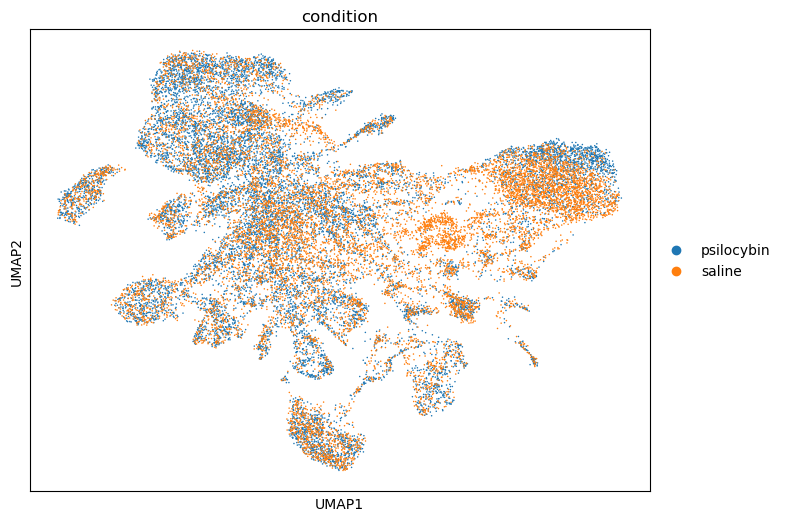

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.umap(adata_bbknn, color="condition", ax=ax)

# Harmony

In [19]:
adata_harmony = adata_hvg.copy()

adata_harmony.X = adata_harmony.layers["logcounts"].copy()
sc.tl.pca(adata_harmony, svd_solver="arpack")

In [20]:
sc.external.pp.harmony_integrate(adata_harmony, "condition")

2024-03-27 15:05:50,689 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-27 15:05:57,884 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-27 15:05:57,943 - harmonypy - INFO - Iteration 1 of 10
2024-03-27 15:06:00,917 - harmonypy - INFO - Iteration 2 of 10
2024-03-27 15:06:03,565 - harmonypy - INFO - Iteration 3 of 10
2024-03-27 15:06:05,215 - harmonypy - INFO - Converged after 3 iterations


In [21]:
sc.pp.neighbors(adata_harmony, use_rep="X_pca_harmony")
sc.tl.umap(adata_harmony)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


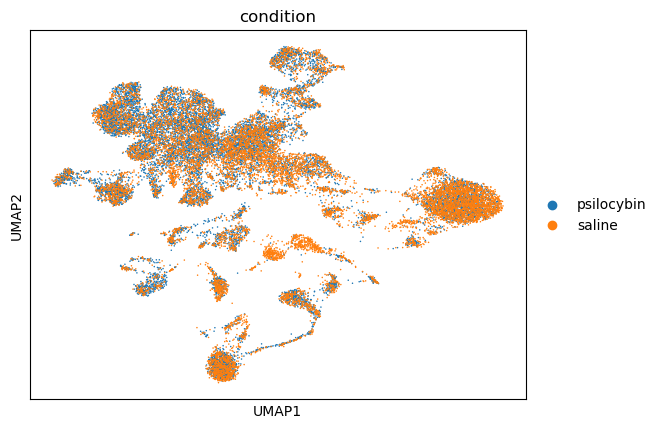

In [22]:
sc.pl.umap(adata_harmony, color="condition")

# scVI

In [23]:
import scvi

In [24]:
adata_scvi = adata_hvg.copy()

In [25]:
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key="condition")

In [26]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [27]:
model_scvi.view_anndata_setup()

Anndata setup with scvi-tools version 1.1.2.

Setup via `SCVI.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'condition',
│   'labels_key': None,
│   'size_factor_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   2   │
│         n_cells          │ 25018 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 2000  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['condition'] │ psilocybin │          0          │
│                        │   saline   │          1          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [28]:
max_epochs_scvi = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scvi

320

In [29]:
model_scvi.train(max_epochs=320)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 320/320: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [26:06<00:00,  4.73s/it, v_num=1, train_loss_step=635, train_loss_epoch=649]

`Trainer.fit` stopped: `max_epochs=320` reached.


Epoch 320/320: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320/320 [26:06<00:00,  4.90s/it, v_num=1, train_loss_step=635, train_loss_epoch=649]


In [30]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.umap(adata_scvi)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


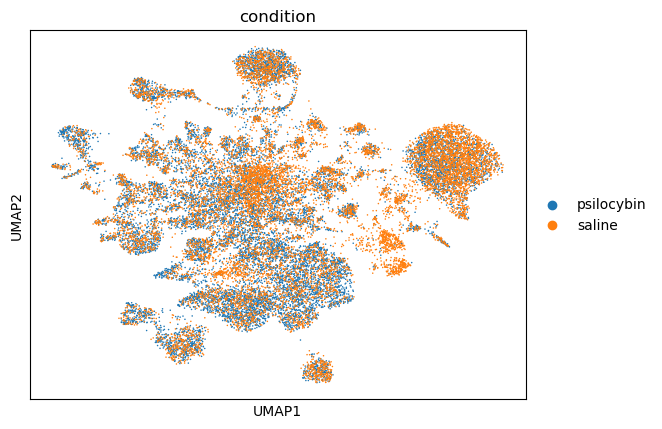

In [31]:
sc.pl.umap(adata_scvi, color="condition")

# scanorama

In [32]:
adata_scanorama = adata_hvg.copy()

adata_scanorama.X = adata_scanorama.layers["logcounts"].copy()
sc.tl.pca(adata_scanorama, svd_solver="arpack")

In [36]:
sc.external.pp.scanorama_integrate(adata_scanorama, 'condition')

[[0.         0.88014352]
 [0.         0.        ]]
Processing datasets psilocybin <=> saline


In [37]:
sc.pp.neighbors(adata_scanorama, use_rep="X_scanorama")
sc.tl.umap(adata_scanorama)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


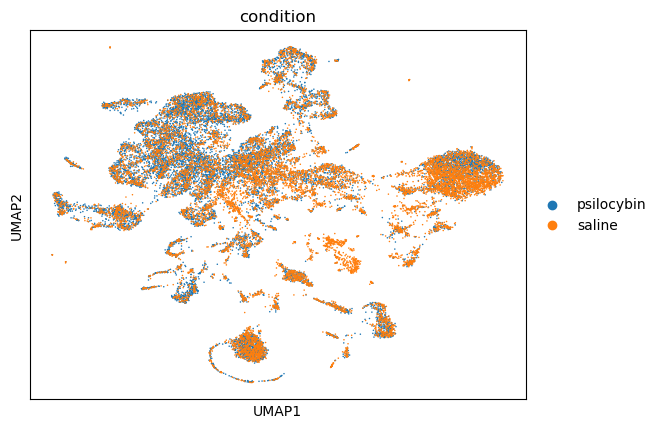

In [38]:
sc.pl.umap(adata_scanorama, color="condition")

# LIGER

In [39]:
import pyliger

In [64]:
saline = adata[adata.obs["condition"] == "saline"].copy()
saline.X = saline.layers["counts"].copy()

psilo = adata[adata.obs["condition"] == "psilocybin"].copy()
psilo.X = psilo.layers["counts"].copy()

saline.uns["sample_name"] = "saline"
psilo.uns["sample_name"] = "psilocybin"

In [65]:
adata_liger = pyliger.create_liger([saline, psilo], make_sparse=False)

Removing 94 genes not expressing in saline.
Removing 230 genes not expressing in psilocybin.


In [66]:
pyliger.normalize(adata_liger)
pyliger.select_genes(adata_liger)
pyliger.scale_not_center(adata_liger)

In [67]:
pyliger.optimize_ALS(adata_liger, k=25)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:36<00:00,  5.21s/it]


In [68]:
pyliger.quantile_norm(adata_liger)

In [76]:
import anndata as ad

In [77]:
adata_liger = ad.concat(adata_liger.adata_list)

In [81]:
sc.pp.neighbors(adata_liger, use_rep="H_norm", n_pcs=25)
sc.tl.umap(adata_liger)

/opt/homebrew/Caskroom/mambaforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


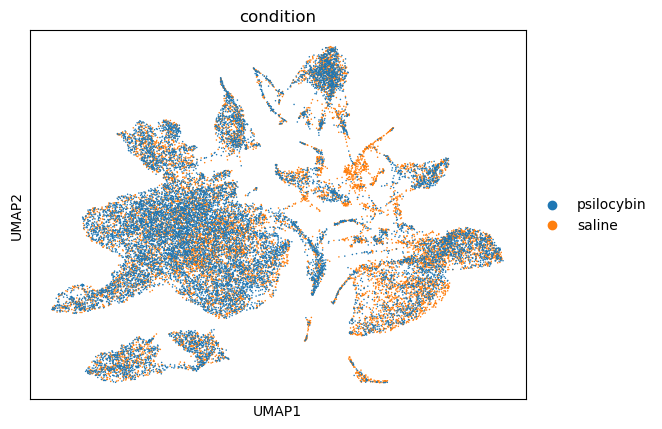

In [82]:
sc.pl.umap(adata_liger, color="condition")